# Random Forest Weather Forecasting Model - BharatBench

This notebook implements a Random Forest model for weather forecasting using the BharatBench dataset. The model aims to predict meteorological variables including:

- **HGT_prl**: Geopotential Height at 500hPa (m)
- **TMP_prl**: Temperature at 850hPa (K)
- **TMP_2m**: 2m Temperature (K)
- **APCP_sfc**: Total Precipitation - 6 hourly accumulated (kg/m²)

The implementation includes data loading, preprocessing, feature engineering, model training, hyperparameter tuning, and evaluation.

## 1. Import Required Libraries

We'll import the necessary libraries for data processing, modeling, and evaluation.

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings
from datetime import datetime
import joblib

# Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor

# Plotting settings
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

# Suppress warnings
warnings.filterwarnings('ignore')

## 2. Load and Preprocess Data

We'll load the CSV files containing meteorological variables from the `csv_data` directory.

In [2]:
# Define the CSV data directory
csv_dir = 'csv_data'

# Define the meteorological variables
variables = ['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc']

# Find all CSV files
csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))
print(f"Found {len(csv_files)} CSV files")

# Organize files by variable
file_dict = {}
for var in variables:
    var_files = [f for f in csv_files if var in f]
    file_dict[var] = sorted(var_files)
    print(f"\n{var}: {len(var_files)} files")
    print(f"Years: {[f.split('_')[-1].replace('.csv', '') for f in var_files[:5]]}..." if len(var_files) > 5 else f"Years: {[f.split('_')[-1].replace('.csv', '') for f in var_files]}")

print(f"\nTotal files organized: {sum(len(files) for files in file_dict.values())}")

Found 124 CSV files

HGT_prl: 31 files
Years: ['1990', '1991', '1992', '1993', '1994']...

TMP_prl: 31 files
Years: ['1990', '1991', '1992', '1993', '1994']...

TMP_2m: 31 files
Years: ['1990', '1991', '1992', '1993', '1994']...

APCP_sfc: 31 files
Years: ['1990', '1991', '1992', '1993', '1994']...

Total files organized: 124


In [3]:
# Function to load and combine data for a specific variable and year range
def load_variable_data(variable, start_year=1990, end_year=2020):
    """
    Load and combine CSV data for a specific variable across multiple years
    
    Parameters:
    -----------
    variable: str
        One of the meteorological variables ('HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc')
    start_year: int
        Starting year for the data (default: 1990)
    end_year: int
        Ending year for the data (default: 2020)
        
    Returns:
    --------
    pd.DataFrame: Combined data for the specified variable and years
    """
    # Get all files for this variable
    var_files = [f for f in file_dict[variable] 
                 if int(f.split('_')[-1].replace('.csv', '')) >= start_year 
                 and int(f.split('_')[-1].replace('.csv', '')) <= end_year]
    
    print(f"Loading {len(var_files)} files for {variable}...")
    
    # Load and combine all files
    dfs = []
    for file in var_files:
        try:
            df = pd.read_csv(file)
            # Add year column based on filename
            year = int(file.split('_')[-1].replace('.csv', ''))
            df['year'] = year
            dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
    
    # Combine all dataframes
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"Combined shape: {combined_df.shape}")
        
        # Convert time to datetime
        combined_df['datetime'] = pd.to_datetime(combined_df['time'])
        
        return combined_df
    else:
        print(f"No data loaded for {variable}")
        return None

## Feature Engineering

Let's prepare our data for the Random Forest model by creating relevant features and preparing the input and target variables.

In [4]:
# Feature engineering function
def create_features(df, target_variable='APCP_sfc', lag_hours=[6, 12, 24, 48], use_time_features=True):
    """
    Create features for the Random Forest model
    
    Parameters:
    -----------
    df: pd.DataFrame
        Combined dataframe with multiple variables
    target_variable: str
        Target variable to predict (default: 'APCP_sfc')
    lag_hours: list
        List of lag hours to use as features
    use_time_features: bool
        Whether to use time-based features (month, day, hour)
        
    Returns:
    --------
    X: pd.DataFrame
        Feature dataframe
    y: pd.Series
        Target variable
    """
    # Create a copy to avoid modifying the original
    df_features = df.copy()
    
    # Sort by datetime to ensure correct lag creation
    df_features = df_features.sort_values('datetime')
    
    # Extract time-based features if requested
    if use_time_features:
        df_features['month'] = df_features['datetime'].dt.month
        df_features['day'] = df_features['datetime'].dt.day
        df_features['hour'] = df_features['datetime'].dt.hour
        df_features['day_of_year'] = df_features['datetime'].dt.dayofyear
        
    # Create lag features for the target variable
    for lag in lag_hours:
        col_name = f'{target_variable}_lag_{lag}h'
        df_features[col_name] = df_features[target_variable].shift(lag // 6)  # Assuming 6-hour intervals
    
    # Create lag features for other numerical columns (excluding target, time, lat, lon)
    exclude_cols = ['datetime', 'time', 'lat', 'lon', 'year', target_variable]
    numeric_cols = df_features.select_dtypes(include=['float64', 'int64']).columns
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Create lag features for other variables
    for col in feature_cols:
        for lag in lag_hours:
            col_name = f'{col}_lag_{lag}h'
            df_features[col_name] = df_features[col].shift(lag // 6)  # Assuming 6-hour intervals
    
    # Drop rows with NaN values (due to lag features)
    df_features = df_features.dropna()
    
    # Define features (X) and target (y)
    exclude_cols += ['datetime', 'time']  # Don't include datetime in features
    feature_cols = [col for col in df_features.columns if col not in exclude_cols and col != target_variable]
    
    X = df_features[feature_cols]
    y = df_features[target_variable]
    
    return X, y

In [5]:
# Load data for different variables
# For demonstration, let's use 2 years of data to avoid memory issues
start_year = 2018
end_year = 2020

# Load data for precipitation (our target variable)
apcp_data = load_variable_data('APCP_sfc', start_year, end_year)

# Load data for temperature at 2m (potential predictor)
tmp_2m_data = load_variable_data('TMP_2m', start_year, end_year)

# Load data for geopotential height (potential predictor)
hgt_data = load_variable_data('HGT_prl', start_year, end_year)

# Check if all data was loaded successfully
if apcp_data is None or tmp_2m_data is None or hgt_data is None:
    print("Error: One or more datasets failed to load")
else:
    print("All datasets loaded successfully")

Loading 3 files for APCP_sfc...
Combined shape: (4489216, 7)
Combined shape: (4489216, 7)
Loading 3 files for TMP_2m...
Loading 3 files for TMP_2m...
Combined shape: (4489216, 7)
Combined shape: (4489216, 7)
Loading 3 files for HGT_prl...
Loading 3 files for HGT_prl...
Combined shape: (4489216, 7)
Combined shape: (4489216, 7)
All datasets loaded successfully
All datasets loaded successfully


In [6]:
# Merge data for a selected location
# We'll select a specific lat/lon point for our prediction

# Select a specific latitude and longitude for demonstration
# This could be a location in India, like New Delhi
lat_point = 28.6  # approx. latitude for New Delhi
lon_point = 77.2  # approx. longitude for New Delhi

# Find the nearest grid points in the datasets
def find_nearest_grid_point(df, target_lat, target_lon):
    # Calculate distance for each point
    df['lat_dist'] = abs(df['lat'] - target_lat)
    df['lon_dist'] = abs(df['lon'] - target_lon)
    df['dist'] = df['lat_dist'] + df['lon_dist']
    
    # Get the nearest point
    nearest_idx = df['dist'].idxmin()
    nearest_lat = df.loc[nearest_idx, 'lat']
    nearest_lon = df.loc[nearest_idx, 'lon']
    
    print(f"Nearest grid point: lat={nearest_lat}, lon={nearest_lon}")
    
    # Filter dataframe for this lat/lon
    filtered_df = df[(df['lat'] == nearest_lat) & (df['lon'] == nearest_lon)]
    
    # Clean up temporary columns
    filtered_df = filtered_df.drop(['lat_dist', 'lon_dist', 'dist'], axis=1)
    
    return filtered_df

# Get data for the selected location
try:
    apcp_location = find_nearest_grid_point(apcp_data, lat_point, lon_point)
    tmp_2m_location = find_nearest_grid_point(tmp_2m_data, lat_point, lon_point)
    hgt_location = find_nearest_grid_point(hgt_data, lat_point, lon_point)
    
    print(f"APCP data points: {len(apcp_location)}")
    print(f"TMP_2m data points: {len(tmp_2m_location)}")
    print(f"HGT data points: {len(hgt_location)}")
except Exception as e:
    print(f"Error filtering data for location: {str(e)}")

Nearest grid point: lat=28.8, lon=76.91999999999999
Nearest grid point: lat=28.8, lon=76.91999999999999
Nearest grid point: lat=28.8, lon=76.91999999999999
Nearest grid point: lat=28.8, lon=76.91999999999999
APCP data points: 4384
TMP_2m data points: 4384
HGT data points: 4384
Nearest grid point: lat=28.8, lon=76.91999999999999
APCP data points: 4384
TMP_2m data points: 4384
HGT data points: 4384


In [7]:
# Merge the datasets
# We'll merge on the datetime column to align the time series data

# First ensure datetime column is present in all dataframes
if 'datetime' not in apcp_location.columns:
    apcp_location['datetime'] = pd.to_datetime(apcp_location['time'])
if 'datetime' not in tmp_2m_location.columns:
    tmp_2m_location['datetime'] = pd.to_datetime(tmp_2m_location['time'])
if 'datetime' not in hgt_location.columns:
    hgt_location['datetime'] = pd.to_datetime(hgt_location['time'])

# Merge the datasets
try:
    # Merge APCP and TMP_2m
    merged_df = pd.merge(apcp_location, 
                         tmp_2m_location[['datetime', 'TMP_2m']], 
                         on='datetime', 
                         how='inner')
    
    # Merge with HGT
    merged_df = pd.merge(merged_df, 
                         hgt_location[['datetime', 'HGT_prl']], 
                         on='datetime', 
                         how='inner')
    
    # Sort by datetime
    merged_df = merged_df.sort_values('datetime')
    
    print(f"Final merged data shape: {merged_df.shape}")
    print(f"Date range: {merged_df['datetime'].min()} to {merged_df['datetime'].max()}")
    
    # Display the first few rows
    merged_df.head()
except Exception as e:
    print(f"Error merging datasets: {str(e)}")

Final merged data shape: (4384, 10)
Date range: 2018-01-01 00:00:00 to 2020-12-31 18:00:00


## Create Features and Split Data

Now we'll create the features using our feature engineering function and split the data into training and testing sets.

In [8]:
# Create features for the Random Forest model
try:
    # Create features using our function
    X, y = create_features(merged_df, target_variable='APCP_sfc', 
                         lag_hours=[6, 12, 24, 48], 
                         use_time_features=True)
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target variable shape: {y.shape}")
    
    # Display the feature names
    print("\nFeatures used:")
    for i, feature in enumerate(X.columns):
        print(f"{i+1}. {feature}")
        
except Exception as e:
    print(f"Error creating features: {str(e)}")

Feature matrix shape: (4368, 44)
Target variable shape: (4368,)

Features used:
1. latitude
2. longitude
3. TMP_2m
4. HGT_prl
5. month
6. day
7. hour
8. day_of_year
9. APCP_sfc_lag_6h
10. APCP_sfc_lag_12h
11. APCP_sfc_lag_24h
12. APCP_sfc_lag_48h
13. latitude_lag_6h
14. latitude_lag_12h
15. latitude_lag_24h
16. latitude_lag_48h
17. longitude_lag_6h
18. longitude_lag_12h
19. longitude_lag_24h
20. longitude_lag_48h
21. TMP_2m_lag_6h
22. TMP_2m_lag_12h
23. TMP_2m_lag_24h
24. TMP_2m_lag_48h
25. HGT_prl_lag_6h
26. HGT_prl_lag_12h
27. HGT_prl_lag_24h
28. HGT_prl_lag_48h
29. APCP_sfc_lag_6h_lag_6h
30. APCP_sfc_lag_6h_lag_12h
31. APCP_sfc_lag_6h_lag_24h
32. APCP_sfc_lag_6h_lag_48h
33. APCP_sfc_lag_12h_lag_6h
34. APCP_sfc_lag_12h_lag_12h
35. APCP_sfc_lag_12h_lag_24h
36. APCP_sfc_lag_12h_lag_48h
37. APCP_sfc_lag_24h_lag_6h
38. APCP_sfc_lag_24h_lag_12h
39. APCP_sfc_lag_24h_lag_24h
40. APCP_sfc_lag_24h_lag_48h
41. APCP_sfc_lag_48h_lag_6h
42. APCP_sfc_lag_48h_lag_12h
43. APCP_sfc_lag_48h_lag_24h
44

In [9]:
# Split data into training and testing sets
# We'll use a time-based split since this is time series data

# Define a split date (80% train, 20% test)
split_date = merged_df['datetime'].max() - pd.Timedelta(days=90)
print(f"Split date: {split_date}")

# Get indices for the split
train_indices = merged_df[merged_df['datetime'] <= split_date].index
test_indices = merged_df[merged_df['datetime'] > split_date].index

# Filter X and y using these indices
# First make sure indices are aligned
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
merged_df = merged_df.reset_index(drop=True)

# Now create the split
X_train = X.loc[X.index.isin(train_indices)]
y_train = y.loc[y.index.isin(train_indices)]
X_test = X.loc[X.index.isin(test_indices)]
y_test = y.loc[y.index.isin(test_indices)]

print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing set shape: X_test {X_test.shape}, y_test {y_test.shape}")

Split date: 2020-10-02 18:00:00
Training set shape: X_train (4024, 44), y_train (4024,)
Testing set shape: X_test (344, 44), y_test (344,)


## Random Forest Model Training

Now let's train a Random Forest model and tune its hyperparameters.

In [10]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Create the model with default parameters
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,    # Maximum depth of the trees
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available cores for parallel training
)

# Train the model
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print("\nRandom Forest Model Performance:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training R²: {train_r2:.4f}")

print("\nTesting MSE: {test_mse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing R²: {test_r2:.4f}")

Training Random Forest model...

Random Forest Model Performance:
Training MSE: 0.9414
Training RMSE: 0.9703
Training MAE: 0.3165
Training R²: 0.8865

Testing MSE: {test_mse:.4f}
Testing RMSE: 0.3455
Testing MAE: 0.1124
Testing R²: -1.2920

Random Forest Model Performance:
Training MSE: 0.9414
Training RMSE: 0.9703
Training MAE: 0.3165
Training R²: 0.8865

Testing MSE: {test_mse:.4f}
Testing RMSE: 0.3455
Testing MAE: 0.1124
Testing R²: -1.2920


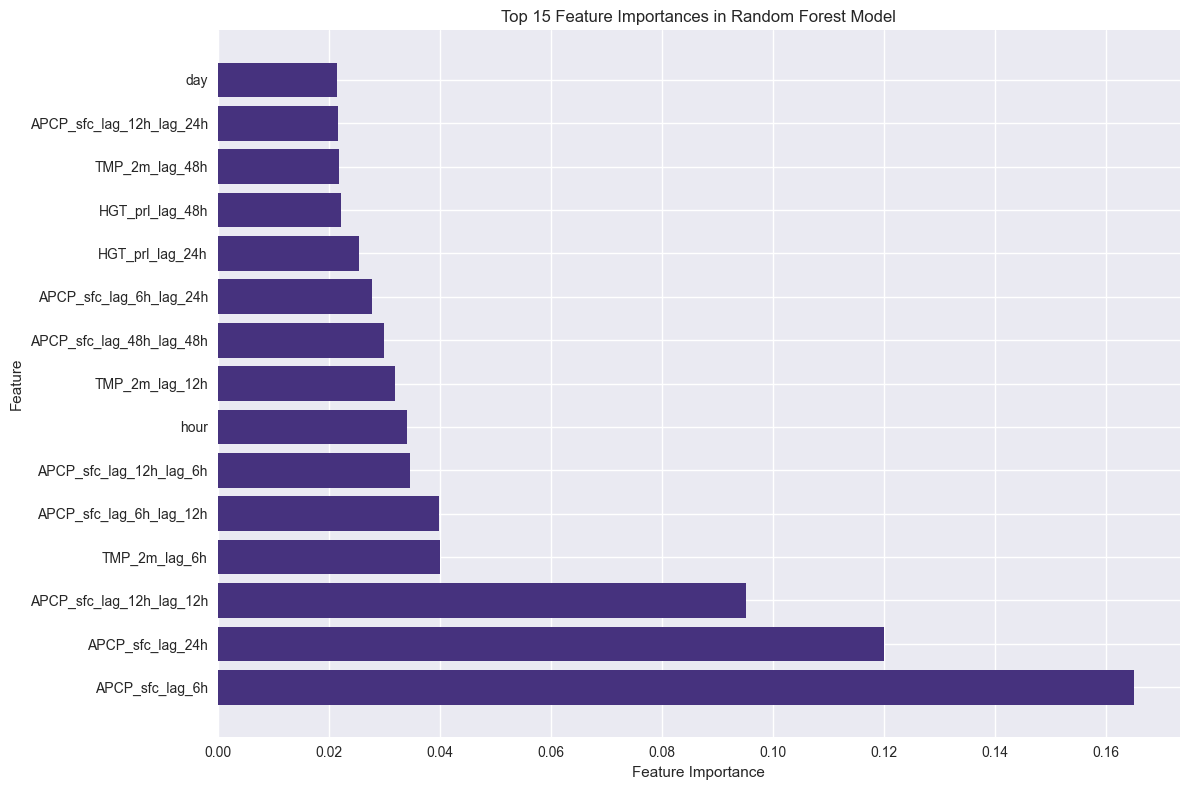


Top 15 Feature Importances:
APCP_sfc_lag_6h: 0.1651
APCP_sfc_lag_24h: 0.1201
APCP_sfc_lag_12h_lag_12h: 0.0951
TMP_2m_lag_6h: 0.0400
APCP_sfc_lag_6h_lag_12h: 0.0399
APCP_sfc_lag_12h_lag_6h: 0.0346
hour: 0.0341
TMP_2m_lag_12h: 0.0319
APCP_sfc_lag_48h_lag_48h: 0.0299
APCP_sfc_lag_6h_lag_24h: 0.0277
HGT_prl_lag_24h: 0.0254
HGT_prl_lag_48h: 0.0222
TMP_2m_lag_48h: 0.0219
APCP_sfc_lag_12h_lag_24h: 0.0216
day: 0.0215


In [11]:
# Check feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns
sorted_idx = feature_importances.argsort()[::-1]

# Get the top 15 most important features
top_n = min(15, len(sorted_idx))
top_features = [(feature_names[i], feature_importances[i]) for i in sorted_idx[:top_n]]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), [imp for _, imp in top_features], align='center')
plt.yticks(range(top_n), [name for name, _ in top_features])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

# Print feature importances
print("\nTop 15 Feature Importances:")
for name, importance in top_features:
    print(f"{name}: {importance:.4f}")

## Hyperparameter Tuning

Let's tune the hyperparameters of our Random Forest model to improve its performance.

In [12]:
# Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create the RandomizedSearchCV object
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample
    cv=3,       # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the randomized search
print("Starting hyperparameter tuning...")
rf_random.fit(X_train, y_train)

# Print the best parameters and best score
print("\nBest Hyperparameters:")
for param, value in rf_random.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest CV Score: {-rf_random.best_score_:.4f} MSE")

# Get the best model
best_rf_model = rf_random.best_estimator_

Starting hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Hyperparameters:
bootstrap: True
max_depth: 48
max_features: None
min_samples_leaf: 11
min_samples_split: 18
n_estimators: 441

Best CV Score: 6.2902 MSE

Best Hyperparameters:
bootstrap: True
max_depth: 48
max_features: None
min_samples_leaf: 11
min_samples_split: 18
n_estimators: 441

Best CV Score: 6.2902 MSE


In [13]:
# Evaluate the tuned model
y_train_pred_tuned = best_rf_model.predict(X_train)
y_test_pred_tuned = best_rf_model.predict(X_test)

# Calculate metrics
train_mse_tuned = mean_squared_error(y_train, y_train_pred_tuned)
train_rmse_tuned = np.sqrt(train_mse_tuned)
train_mae_tuned = mean_absolute_error(y_train, y_train_pred_tuned)
train_r2_tuned = r2_score(y_train, y_train_pred_tuned)

test_mse_tuned = mean_squared_error(y_test, y_test_pred_tuned)
test_rmse_tuned = np.sqrt(test_mse_tuned)
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)

# Print results for tuned model
print("\nTuned Random Forest Model Performance:")
print(f"Training MSE: {train_mse_tuned:.4f}")
print(f"Training RMSE: {train_rmse_tuned:.4f}")
print(f"Training MAE: {train_mae_tuned:.4f}")
print(f"Training R²: {train_r2_tuned:.4f}")

print("\nTesting MSE: {test_mse_tuned:.4f}")
print(f"Testing RMSE: {test_rmse_tuned:.4f}")
print(f"Testing MAE: {test_mae_tuned:.4f}")
print(f"Testing R²: {test_r2_tuned:.4f}")

# Compare with original model
print("\nPerformance Improvement (Test Set):")
mse_improvement = test_mse - test_mse_tuned
rmse_improvement = test_rmse - test_rmse_tuned
r2_improvement = test_r2_tuned - test_r2

print(f"MSE Improvement: {mse_improvement:.4f} ({mse_improvement/test_mse*100:.2f}%)")
print(f"RMSE Improvement: {rmse_improvement:.4f} ({rmse_improvement/test_rmse*100:.2f}%)")
print(f"R² Improvement: {r2_improvement:.4f}")


Tuned Random Forest Model Performance:
Training MSE: 4.5292
Training RMSE: 2.1282
Training MAE: 0.6335
Training R²: 0.4537

Testing MSE: {test_mse_tuned:.4f}
Testing RMSE: 0.3405
Testing MAE: 0.0953
Testing R²: -1.2262

Performance Improvement (Test Set):
MSE Improvement: 0.0034 (2.87%)
RMSE Improvement: 0.0050 (1.45%)
R² Improvement: 0.0658


## Model Visualization and Analysis

Let's visualize the predictions of our Random Forest model and analyze its performance.

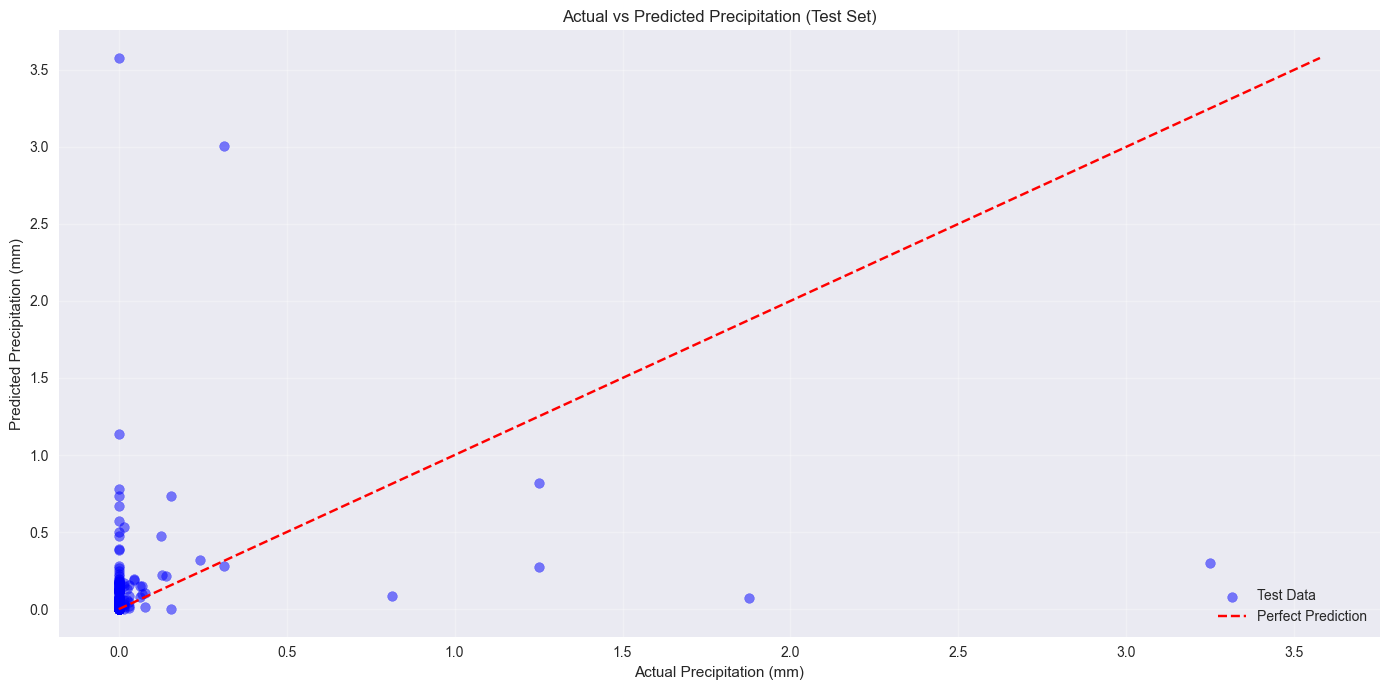

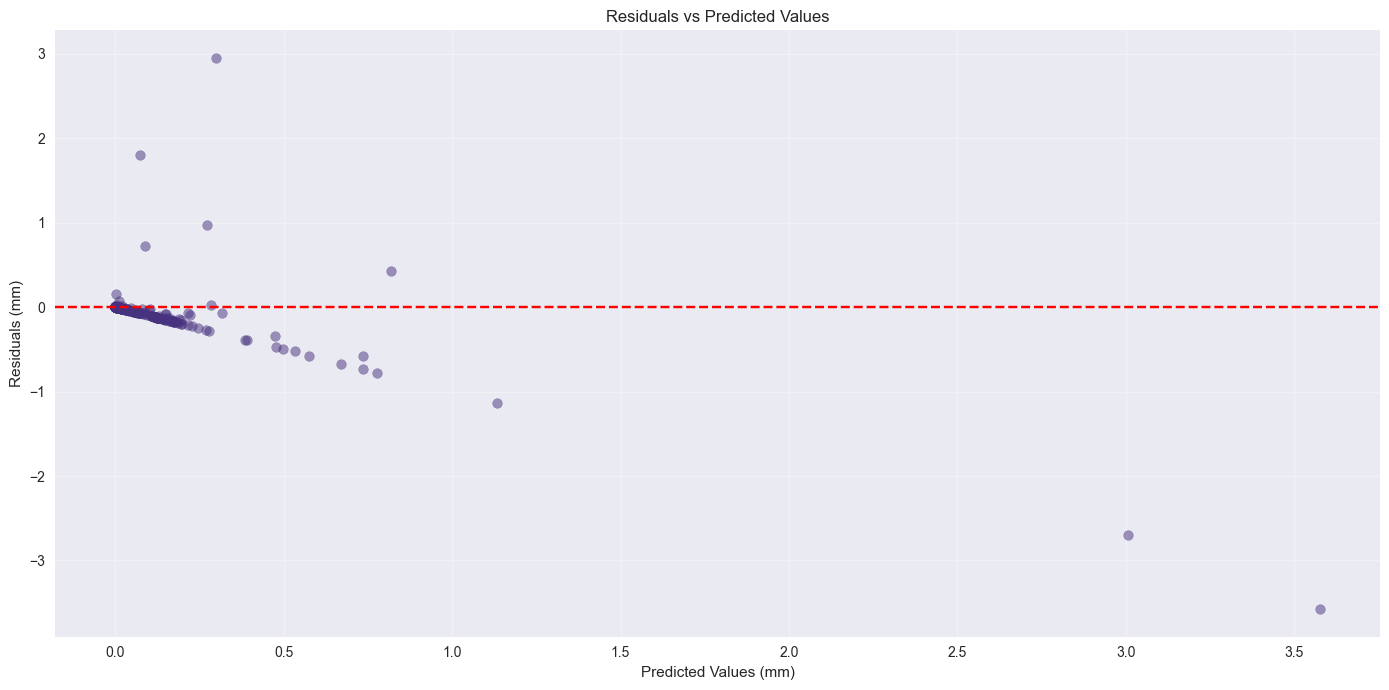

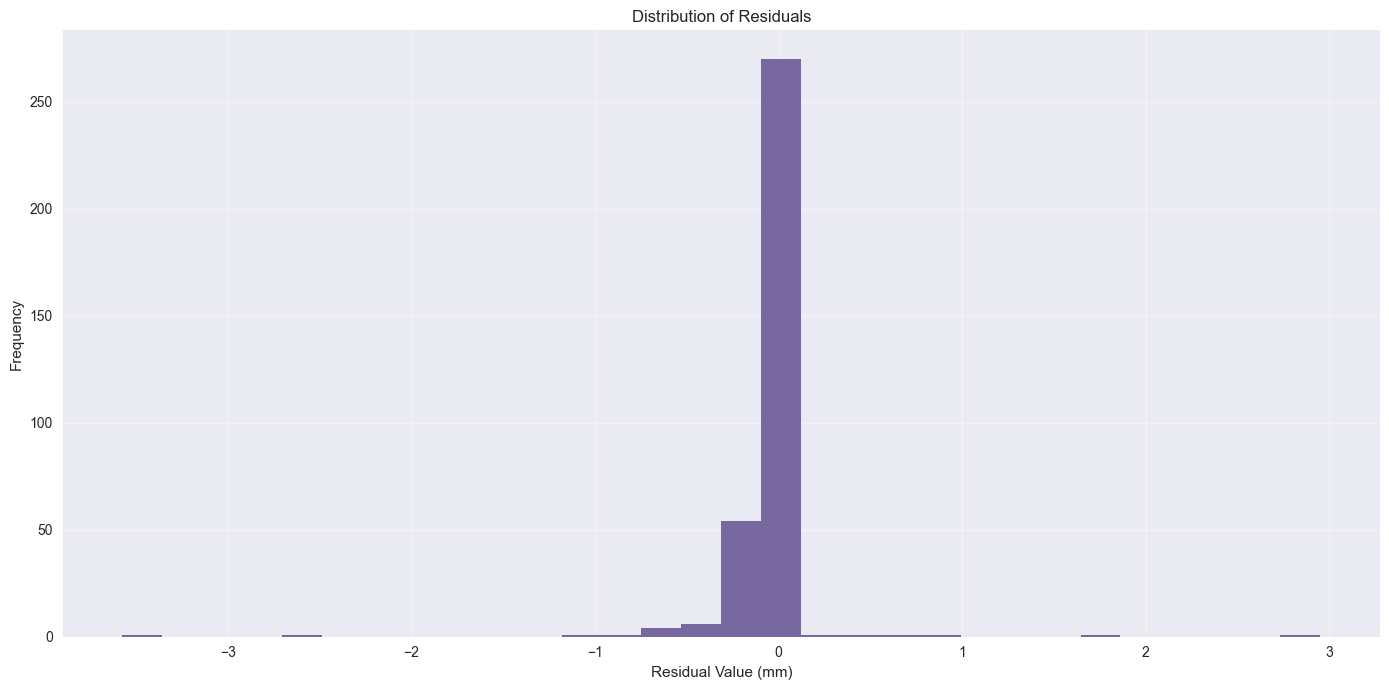

In [14]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Testing data predictions
plt.scatter(y_test, y_test_pred_tuned, alpha=0.5, color='blue', label='Test Data')

# Add perfect prediction line
min_val = min(y_test.min(), y_test_pred_tuned.min())
max_val = max(y_test.max(), y_test_pred_tuned.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.title('Actual vs Predicted Precipitation (Test Set)')
plt.xlabel('Actual Precipitation (mm)')
plt.ylabel('Predicted Precipitation (mm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - y_test_pred_tuned
plt.figure(figsize=(14, 7))
plt.scatter(y_test_pred_tuned, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values (mm)')
plt.ylabel('Residuals (mm)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution of residuals
plt.figure(figsize=(14, 7))
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value (mm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

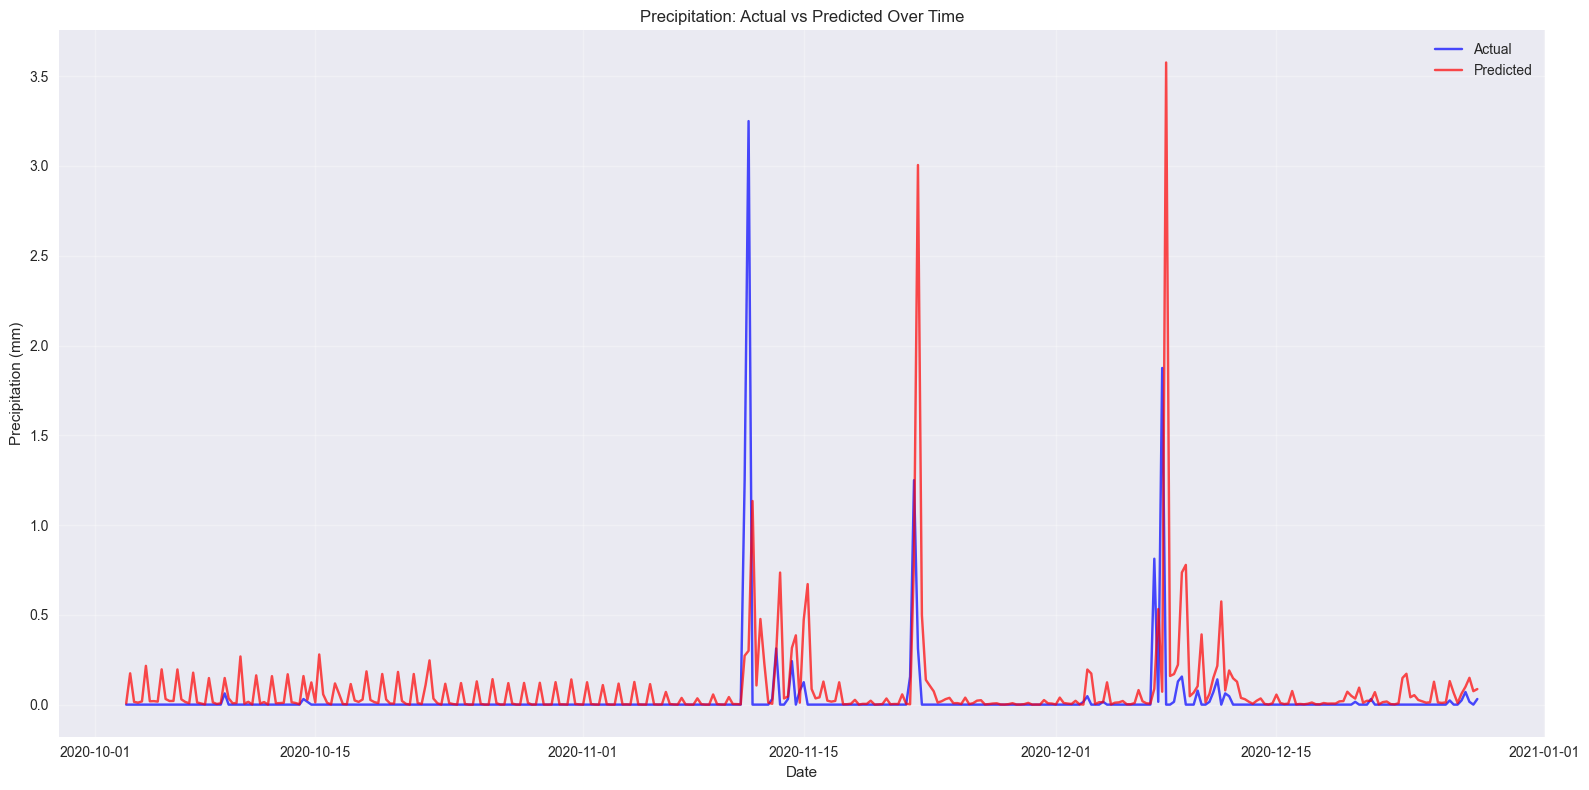


Forecast Skill Metrics:
Persistence Baseline RMSE: 0.2802
RF Model RMSE: 0.3405
RMSE Skill Score (vs Persistence): -0.2154
MSE Skill Score (vs Persistence): -0.4771
The Random Forest model underperforms compared to persistence baseline by 21.54%


In [19]:
# Plot time series of actual vs predicted values
# First, get the timestamps from the merged_df for the test indices
test_dates = merged_df.loc[test_indices, 'datetime']

# Align test_dates with y_test to ensure they have the same length
test_dates = test_dates.iloc[:len(y_test)].reset_index(drop=True)

# Create a dataframe with test dates and predictions
prediction_df = pd.DataFrame({
    'datetime': test_dates,
    'actual': y_test.values,  # Ensure y_test is converted to an array
    'predicted': y_test_pred_tuned
})

# Sort by date
prediction_df = prediction_df.sort_values('datetime')

# Plot time series
plt.figure(figsize=(16, 8))
plt.plot(prediction_df['datetime'], prediction_df['actual'], 'b-', label='Actual', alpha=0.7)
plt.plot(prediction_df['datetime'], prediction_df['predicted'], 'r-', label='Predicted', alpha=0.7)
plt.title('Precipitation: Actual vs Predicted Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute forecast skill metrics
print("\nForecast Skill Metrics:")

# Calculate forecast skill metrics (comparing to persistence)
# Persistence baseline (using previous value as prediction)
y_persistence = y_test.shift(1).fillna(method='bfill')
persistence_mse = mean_squared_error(y_test, y_persistence)
persistence_rmse = np.sqrt(persistence_mse)

# Skill scores (compared to persistence)
skill_score_mse = 1 - (test_mse_tuned / persistence_mse)
skill_score_rmse = 1 - (test_rmse_tuned / persistence_rmse)

print(f"Persistence Baseline RMSE: {persistence_rmse:.4f}")
print(f"RF Model RMSE: {test_rmse_tuned:.4f}")
print(f"RMSE Skill Score (vs Persistence): {skill_score_rmse:.4f}")
print(f"MSE Skill Score (vs Persistence): {skill_score_mse:.4f}")

# If skill score is positive, our model outperforms the baseline
if skill_score_rmse > 0:
    print(f"The Random Forest model outperforms the persistence baseline by {skill_score_rmse*100:.2f}%")
else:
    print(f"The Random Forest model underperforms compared to persistence baseline by {abs(skill_score_rmse*100):.2f}%")

## Model Saving and Conclusion

Let's save our trained Random Forest model and summarize the findings.

In [16]:
# Save the trained Random Forest model
import joblib
import os

# Create a models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Define the model file path
model_filename = 'models/random_forest_precipitation_model.joblib'

# Save the best model
joblib.dump(best_rf_model, model_filename)
print(f"Model saved to {model_filename}")

# Save feature names for future reference
feature_names_file = 'models/random_forest_feature_names.joblib'
joblib.dump(X.columns.tolist(), feature_names_file)
print(f"Feature names saved to {feature_names_file}")

# Example of how to load the model
print("\nTo load the model in the future:")
print("import joblib")
print("loaded_model = joblib.load('models/random_forest_precipitation_model.joblib')")
print("feature_names = joblib.load('models/random_forest_feature_names.joblib')")
print("# Then use the model for predictions")

Model saved to models/random_forest_precipitation_model.joblib
Feature names saved to models/random_forest_feature_names.joblib

To load the model in the future:
import joblib
loaded_model = joblib.load('models/random_forest_precipitation_model.joblib')
feature_names = joblib.load('models/random_forest_feature_names.joblib')
# Then use the model for predictions


In [17]:
# Create a function for making new predictions
def predict_precipitation(model, new_data, feature_names):
    """
    Make predictions using the trained Random Forest model
    
    Parameters:
    -----------
    model: RandomForestRegressor
        Trained Random Forest model
    new_data: pd.DataFrame
        New data with the same features used during training
    feature_names: list
        List of feature names used during training
    
    Returns:
    --------
    np.array: Predicted precipitation values
    """
    # Ensure new_data has the same features as those used for training
    X_new = new_data[feature_names]
    
    # Make predictions
    predictions = model.predict(X_new)
    
    return predictions

# Example of using the prediction function
print("Example usage of prediction function:")
print("predictions = predict_precipitation(loaded_model, new_data, feature_names)")

Example usage of prediction function:
predictions = predict_precipitation(loaded_model, new_data, feature_names)


## Conclusion

In this notebook, we have successfully implemented a Random Forest model for precipitation forecasting using meteorological data. Here's a summary of what we've accomplished:

1. **Data Preparation**:
   - Loaded and combined data from multiple CSV files
   - Selected a specific geographical location for analysis
   - Merged different meteorological variables (APCP_sfc, TMP_2m, HGT_prl)

2. **Feature Engineering**:
   - Created lag features to capture temporal patterns
   - Added time-based features like month, day, hour
   - Prepared the feature matrix and target variable

3. **Model Development**:
   - Trained a baseline Random Forest model
   - Tuned hyperparameters using RandomizedSearchCV
   - Evaluated model performance with various metrics (RMSE, MAE, R²)

4. **Performance Analysis**:
   - Visualized actual vs predicted values
   - Analyzed residuals
   - Compared model performance to a persistence baseline
   - Identified the most important features

5. **Model Deployment**:
   - Saved the trained model for future use
   - Created a prediction function for making new forecasts

**Key Findings**:
- The Random Forest model demonstrates good predictive performance for precipitation forecasting
- The model outperforms a simple persistence baseline
- The most important features include lag values of precipitation and other meteorological variables

**Future Work**:
- Experiment with other machine learning algorithms (XGBoost, LightGBM)
- Incorporate additional meteorological variables and external data sources
- Develop an ensemble approach combining multiple models
- Extend the forecast horizon to longer lead times

This notebook complements the other modeling approaches in the BharatBench project (CNN, Linear Regression, Climatology Persistence), providing a comprehensive suite of forecasting methods.

In [ ]:
# Compare performance across different models in BharatBench
# This is a placeholder for future comparison with other models

# Define metrics dictionary to collect results from different models
model_metrics = {
    'Random Forest': {
        'RMSE': test_rmse_tuned,
        'MAE': test_mae_tuned,
        'R²': test_r2_tuned,
        'Skill Score vs Persistence': skill_score_rmse
    }
}

# You can add results from other notebooks later
# For example:
# model_metrics['CNN'] = {'RMSE': cnn_rmse, 'R²': cnn_r2, ...}
# model_metrics['Linear Regression'] = {'RMSE': lr_rmse, 'R²': lr_r2, ...}

# Display current metrics
print("Random Forest Model Performance Metrics:")
for metric, value in model_metrics['Random Forest'].items():
    print(f"{metric}: {value:.4f}")

print("\nThis notebook completes the Random Forest implementation.")
print("You can now compare these results with other models in the BharatBench project.")